# LoFi on logistic regression

In [336]:
import jax
import distrax
import pandas as pd
import numpy as np
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp

from time import time
from jax.flatten_util import ravel_pytree
from rebayes.utils import utils
from rebayes.datasets import datasets
from rebayes.low_rank_filter import lofi
from rebayes.low_rank_filter import lrvga
from rebayes.extended_kalman_filter import ekf
from rebayes.sgd_filter import replay_sgd

tfd = tfp.distributions

In [167]:
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["lines.linewidth"] = 1.5

<AxesSubplot: ylabel='Count'>

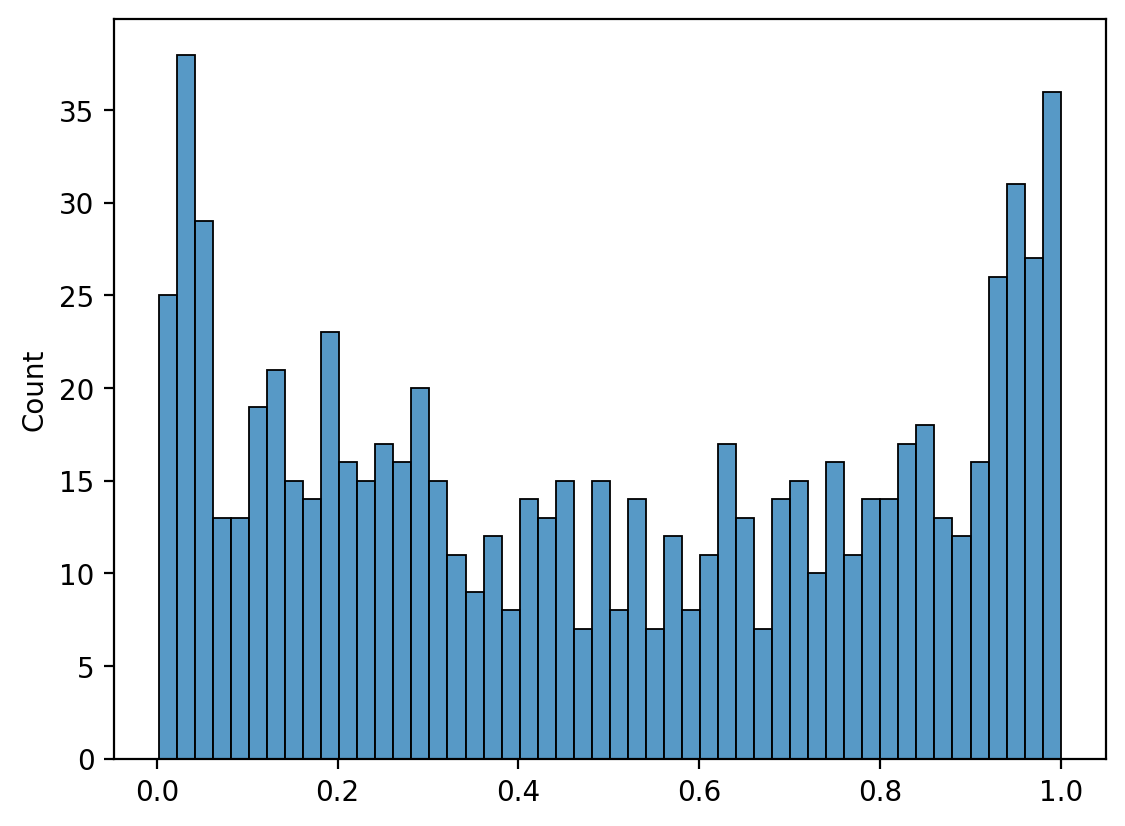

In [3]:
num_train = 800
num_test = 1_000
num_features = 200

dgenerator = datasets.LRDataset(
    dim_inputs=num_features,
    sigma=1.0,
    scale=5.0,
    condition_number=0.05
)

key = jax.random.PRNGKey(314)
key_train, key_test, key_model = jax.random.split(key, 3)

gstate, (X_train, y_train) = dgenerator.sample_train(key_train, num_train)
X_test, y_test = dgenerator.sample_test(key_test, gstate, 1_000)

y_train = jax.nn.sigmoid(y_train)
y_test = jax.nn.sigmoid(y_test)

sns.histplot(y_train, bins=50)

In [4]:
def get_acc(X, y, w):
    yhat = meanfn(w, X).ravel() > 0.5
    acc = (y > 0.5) == yhat
    return acc.mean()

def callback(bel, pred_obs, t, Xt, Yt, bel_pred, **kwargs):
    
    acc_train = get_acc(X_train, y_train, bel.mean)
    acc_test = get_acc(X_test, y_test, bel.mean)
    
    metric = {
        "train": 1 - acc_train,
        "test": 1 - acc_test
    }
    
    return metric

In [5]:
class LogReg(nn.Module):
    n_out: int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_out)(x)
        return x

In [27]:
model = LogReg(1)
params_init = model.init(key_model, X_train)
params_init, rfn = ravel_pytree(params_init)

In [28]:
def meanfn(w, x):
    log_mu = model.apply(rfn(w), x)
    mu = jax.nn.sigmoid(log_mu)
    return mu

def covfn(w, x):
    mu = meanfn(w, x)
    return mu * (1 - mu)

In [29]:
memory_sizes = [1, 20, 30, 50, 70, 100]

In [327]:
%%time
res_lofi = {}
for memory in memory_sizes:
    agent = lofi.RebayesLoFiDiagonal(
        dynamics_weights=0.9999, # 1.0
        dynamics_covariance=1e-5, # 1e-7
        emission_mean_function=meanfn,
        emission_cov_function=covfn,
        emission_dist=lambda mean, cov: tfd.Bernoulli(loc=mean),
        memory_size=memory
    )

    bel, hist = agent.scan(
        params_init, 5e-3, X_train, y_train > 0.5, progress_bar=True, callback=callback
    )
    
    res_lofi[memory] = hist

res_lofi = jax.tree_map(np.array, res_lofi)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

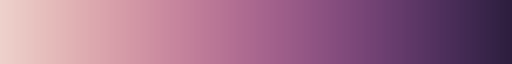

In [328]:
res_lofi_df = pd.DataFrame(utils.get_subtree(res_lofi, "test"))
res_lofi_df.index.name = "num. observations"
res_lofi_df = res_lofi_df.reset_index()
cmap = sns.cubehelix_palette(as_cmap=True)
cmap

Text(0, 0.5, 'missclassification rate')

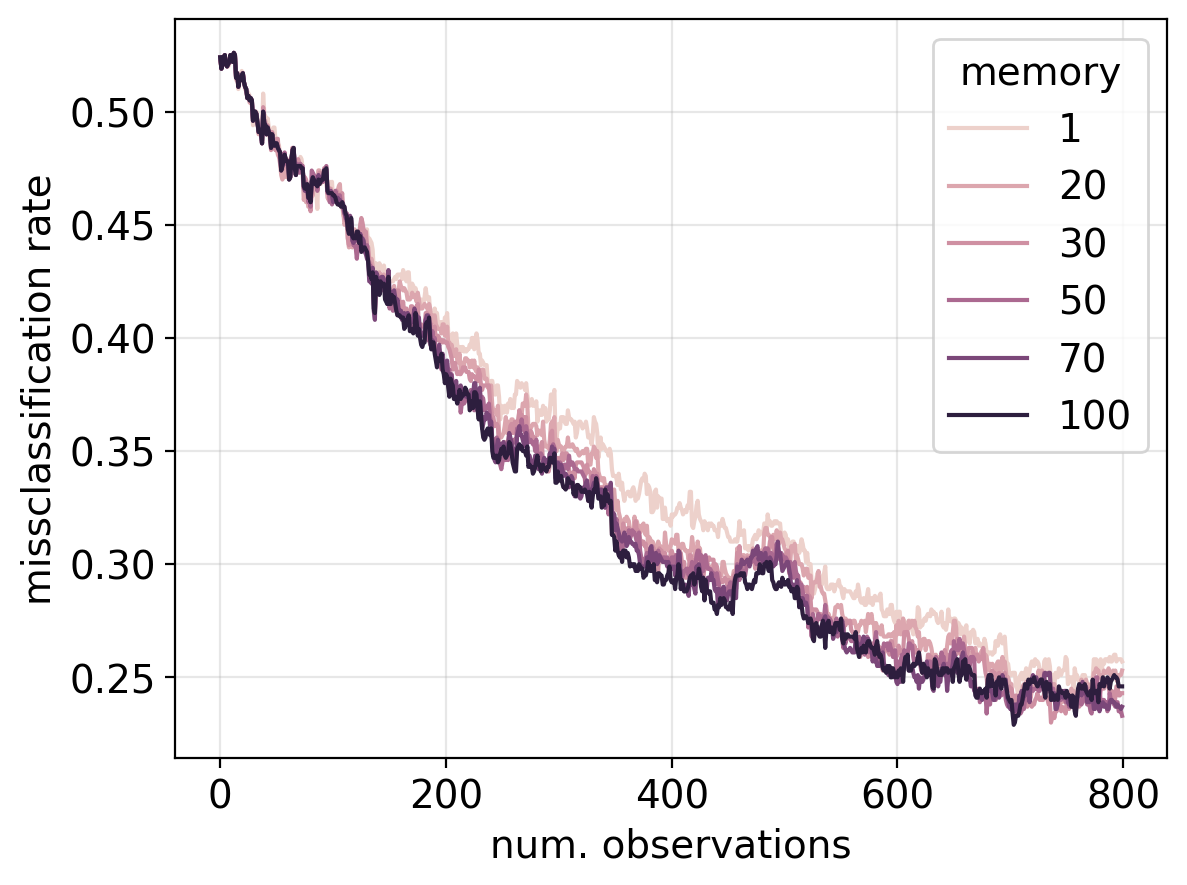

In [329]:
sns.lineplot(
    x="num. observations",
    y="value",
    hue="memory",
    data=res_lofi_df.melt(id_vars="num. observations", var_name="memory"),
    palette=cmap
)
plt.grid(alpha=0.3)
plt.ylabel("missclassification rate")

## L-RVGA

In [139]:
def fwd_link(w, bel, x):
    log_mu = model.apply(rfn(w), x)
    mu = jax.nn.sigmoid(log_mu)
    return mu, mu * (1 - mu)


def log_prob(mean, bel, x, y):
    mu, _ = fwd_link(mean, bel, x)
    
    logp = distrax.Bernoulli(mu).log_prob(y).sum()
    return logp

In [234]:
res_lrvga = {}

hparams = {
    "sigma2": 0.99,
    "eps": 1e-2, # 1e-3
    "std": 1.0,
}

for memory in memory_sizes:
    agent = lrvga.LRVGA(
        fwd_link=fwd_link,
        log_prob=log_prob,
        n_samples=20,
        n_inner=5,
        n_outer=5
    )
    
    bel_init, reconstruct_fn = lrvga.init_lrvga(key, model, X_train, memory, **hparams)
    bel, hist = agent.scan(
        bel_init, 5e-3, X_train, y_train > 0.5, progress_bar=True, callback=callback,
        bel=bel_init,
    )
    
    res_lrvga[memory] = hist
res_lrvga = jax.tree_map(np.array, res_lrvga)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Text(0, 0.5, 'missclassification rate')

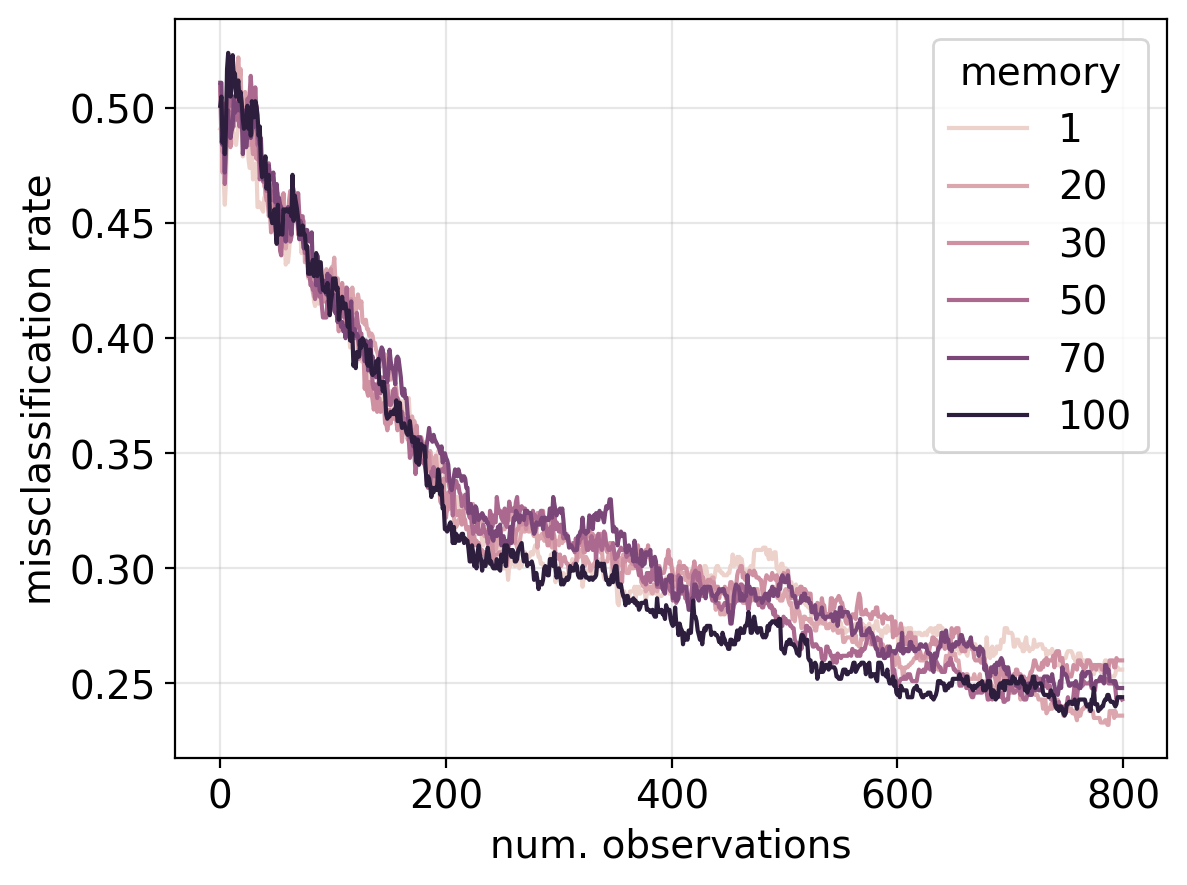

In [235]:
res_lrvga_df = pd.DataFrame(utils.get_subtree(res_lrvga, "test"))
res_lrvga_df.index.name = "num. observations"
res_lrvga_df = res_lrvga_df.reset_index()

sns.lineplot(
    x="num. observations",
    y="value",
    hue="memory",
    data=res_lrvga_df.melt(id_vars="num. observations", var_name="memory"),
    palette=cmap
)
plt.grid(alpha=0.3)
plt.ylabel("missclassification rate")

## R-SGD

In [246]:
def xentropy(y, yhat):
    loss = y * jnp.log(yhat) + (1 - y) * jnp.log(1 - yhat)
    return -loss.mean()

In [305]:
from functools import partial 

def get_acc(X, y, w):
    yhat = model.apply(w, X).ravel() > 0.5
    acc = (y > 0.5) == yhat
    return acc.mean()

def callback(bel, pred_obs, t, Xt, Yt, bel_pred, **kwargs):
    
    acc_train = get_acc(X_train, y_train, bel.mean)
    acc_test = get_acc(X_test, y_test, bel.mean)
    
    metric = {
        "train": 1 - acc_train,
        "test": 1 - acc_test
    }
    
    return metric


@partial(jax.jit, static_argnames=("apply_fn",))
def lossfn_xentropy(params, counter, X, y, apply_fn):
    """
    Loss function for one-hot encoded classification
    problems.
    """
    yhat = apply_fn(params, X)
    yhat = jax.nn.sigmoid(yhat).squeeze()
    
    y = y.squeeze()
    
    loss = - (y * jnp.log(yhat) + (1 - y) * jnp.log(1 - yhat)) * counter
    loss = loss.sum() / counter.sum()

    # logits = jnp.log(yhat) # B x K
    # loss = -jnp.einsum("b...,b...,b->", logits, y, counter) / counter.sum()
    return loss

In [306]:
res_rsgd = {}
bel_init = model.init(key, X_train)

tx = optax.adam(1e-3)
for memory in memory_sizes:
    agent = replay_sgd.FifoSGD(
        lossfn_xentropy,
        model.apply,
        tx,
        memory,
        num_features,
        1
    )

    bel, hist = agent.scan(
        bel_init, 5e-3, X_train, y_train > 0.5, progress_bar=True, callback=callback
    )

    
    res_rsgd[memory] = hist
res_rsgd = jax.tree_map(np.array, res_rsgd)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Text(0, 0.5, 'missclassification rate')

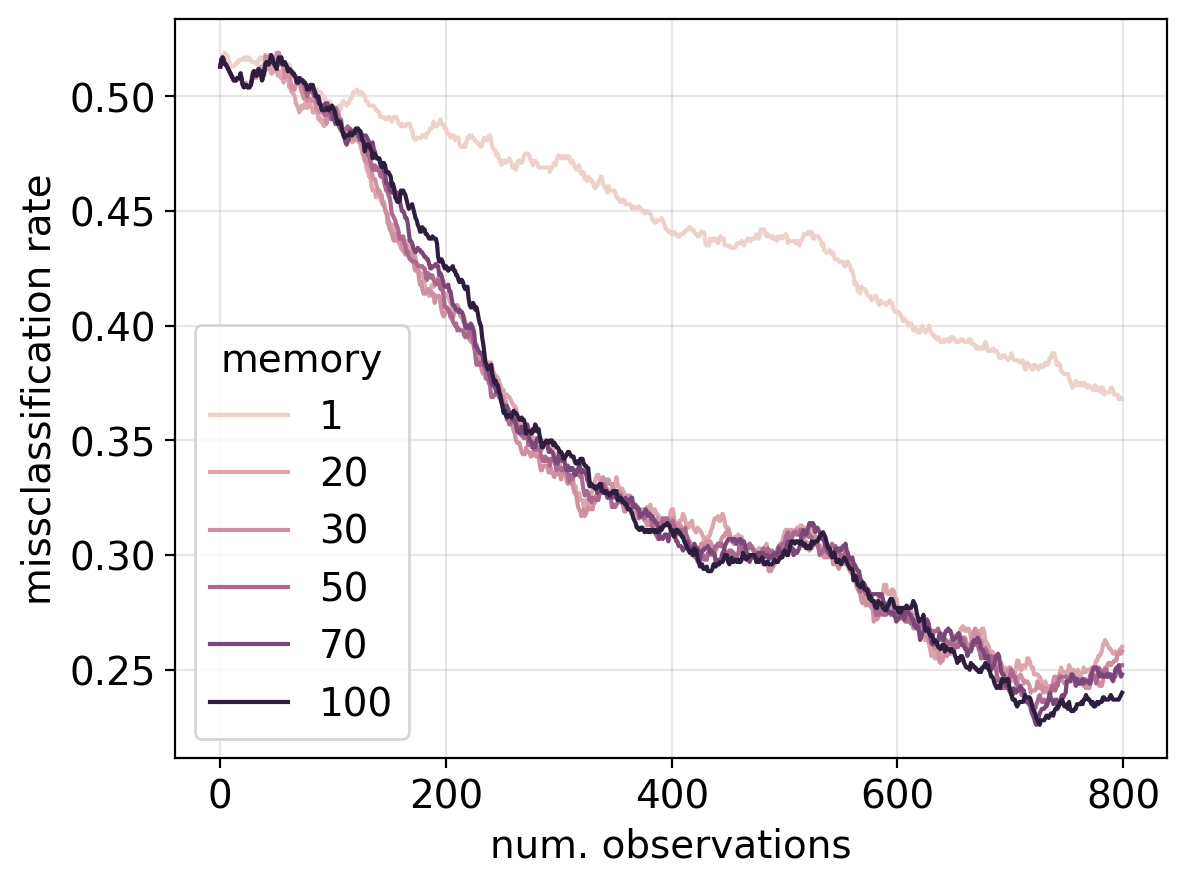

In [307]:
res_rsgd_df = pd.DataFrame(utils.get_subtree(res_rsgd, "test"))
res_rsgd_df.index.name = "num. observations"
res_rsgd_df = res_rsgd_df.reset_index()

sns.lineplot(
    x="num. observations",
    y="value",
    hue="memory",
    data=res_rsgd_df.melt(id_vars="num. observations", var_name="memory"),
    palette=cmap
)
plt.grid(alpha=0.3)
plt.ylabel("missclassification rate")

## FCEKF

In [308]:
def get_acc(X, y, w):
    yhat = meanfn(w, X).ravel() > 0.5
    acc = (y > 0.5) == yhat
    return acc.mean()


agent = ekf.RebayesEKF(
    dynamics_weights_or_function=1.0,
    dynamics_covariance=1e-7,
    emission_mean_function=meanfn,
    emission_cov_function=covfn,
    emission_dist=lambda mean, cov: tfd.Bernoulli(loc=mean),
)

bel, res_ekf = agent.scan(
    params_init, 5e-3, X_train, y_train > 0.5, progress_bar=True, callback=callback
)


  0%|          | 0/800 [00:00<?, ?it/s]

In [309]:
res_ekf_df = pd.DataFrame({"full": np.array(res_ekf["test"])})
res_ekf_df.index.name = "num. observations"
res_ekf_df = res_ekf_df.reset_index()

## Showdown!

In [331]:
res_melt = pd.concat([
    res_lrvga_df.melt(id_vars="num. observations", var_name="memory").assign(method="lrvga"),
    res_lofi_df.melt(id_vars="num. observations", var_name="memory").assign(method="lofi"),
    res_rsgd_df.melt(id_vars="num. observations", var_name="memory").assign(method="rsgd"),
    res_ekf_df.melt(id_vars="num. observations", var_name="memory").assign(method="ekf"),
])
# res_melt["memory"] = res_melt["memory"].astype(int)

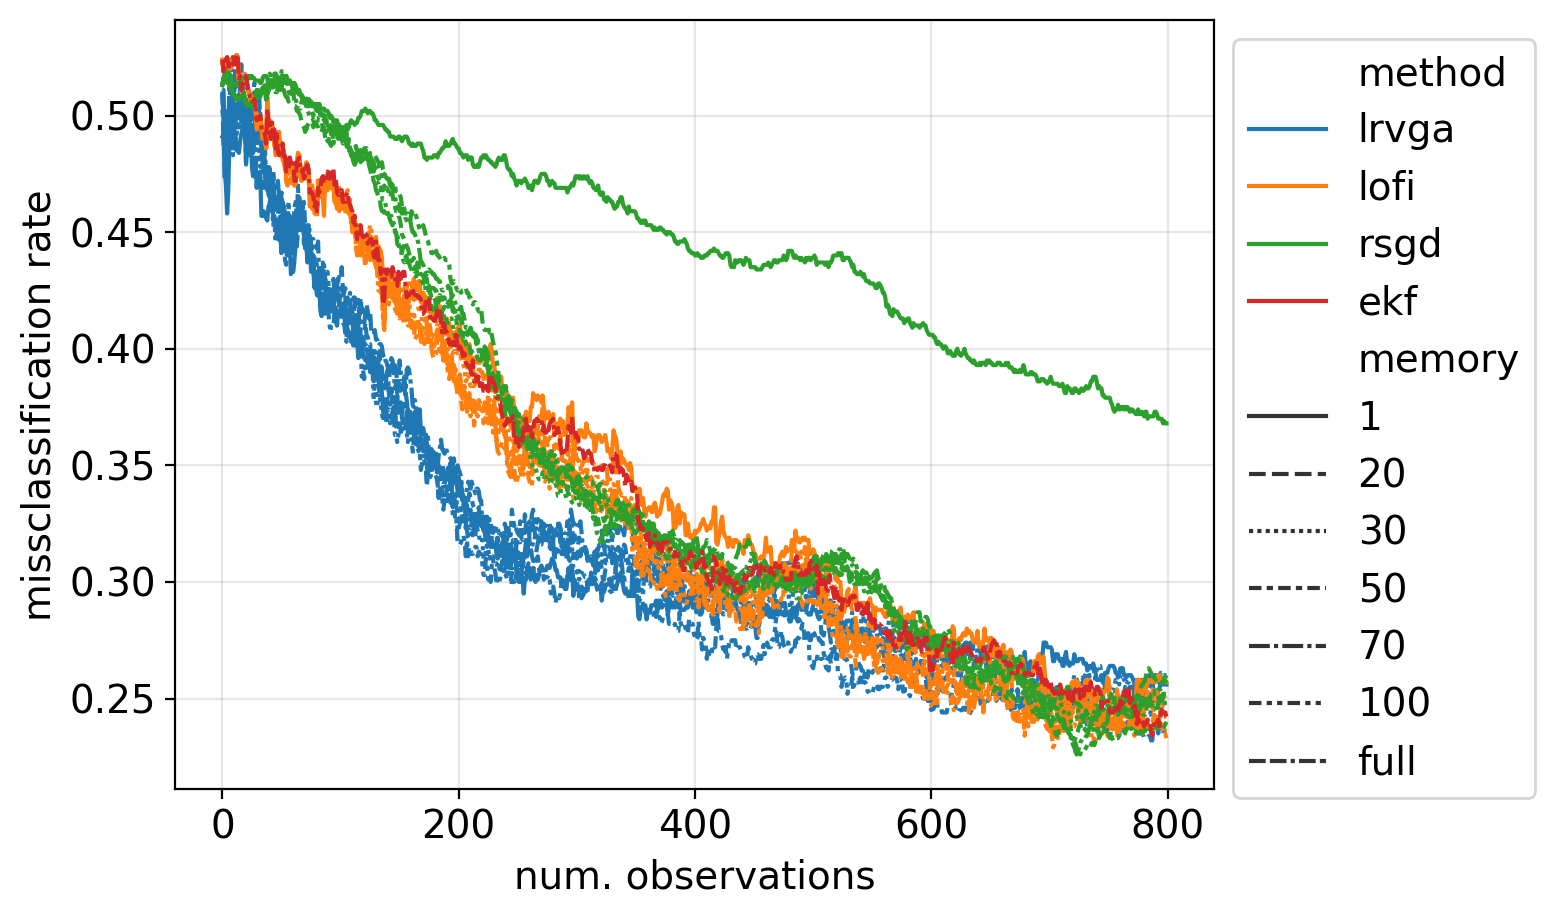

In [332]:
fig, ax = plt.subplots(figsize=(8, 4.8))

sns.lineplot(
    x="num. observations",
    y="value",
    style="memory",
    hue="method",
    data=res_melt,
)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("missclassification rate")
plt.tight_layout()
plt.grid(alpha=0.3)

Text(0, 0.5, 'missclassification rate')

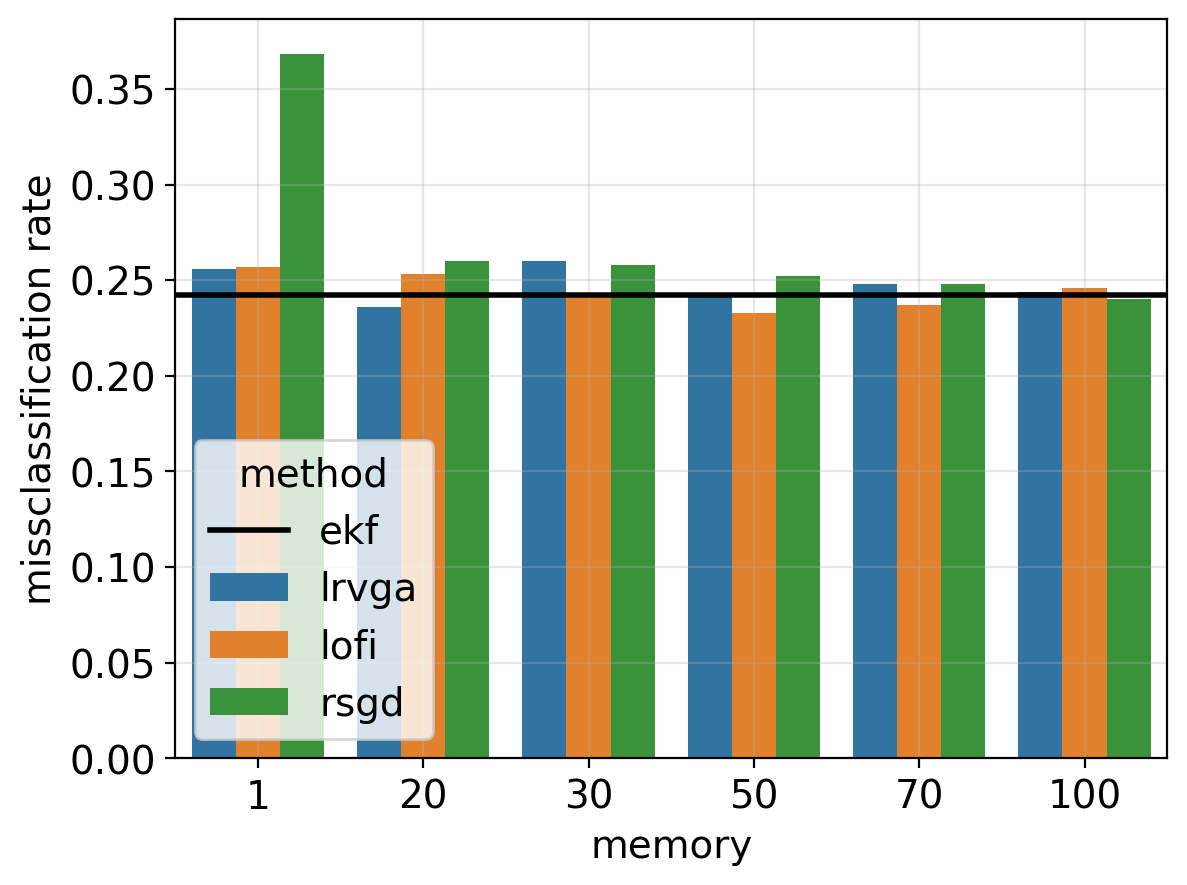

In [333]:
ekf_final = res_melt[res_melt["num. observations"] == num_train -1].query("method == 'ekf'")["value"].item()

fig, ax = plt.subplots()

plt.axhline(y=ekf_final, c="black", linewidth=2, label="ekf")
sns.barplot(
    y="value",
    x="memory",
    hue="method",
    data=res_melt[res_melt["num. observations"] == num_train-1].query("method != 'ekf'"),
)



plt.grid(alpha=0.3)
plt.ylabel("missclassification rate")